In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

In [37]:
dt_tweets = pd.read_pickle('dt_ratings.pickle')

In [39]:
dt_tweets.head();

In [2]:
master_df = pd.read_pickle('dt_master.pickle')

In [4]:
master_df.head(3)

,net_approval,Price,compound,sentiment,trump_kw,trump_mueller_kw
2017-01-23,4.400803,19799.85,0.4939,0.0,100.0,0.0
2017-01-24,3.939187,19912.71,0.9753,0.0,100.0,0.0
2017-01-25,4.297997,20068.51,0.1605,3.0,100.0,0.0


In [5]:
#Define price and rate of change
data = master_df

#Price dataframe
djia_df = data.drop(['net_approval', 'compound', 'sentiment', 'trump_kw', 'trump_mueller_kw'], axis=1)

#variables df
variables_df = data.drop(['Price'], axis =1)

In [6]:
#Calculate percent change
djia_df['djia_per'] = djia_df.pct_change().fillna(method='bfill')

## Stationarity

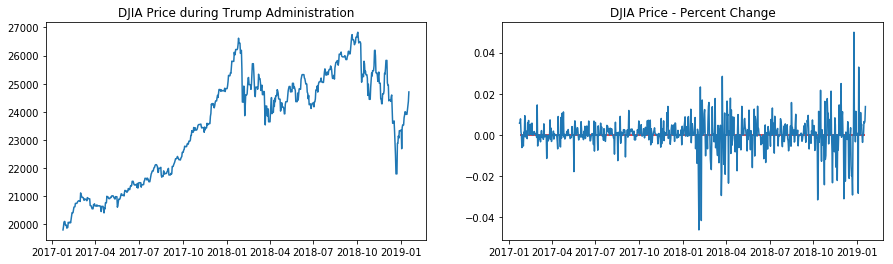

In [8]:
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))

# Levels
axes[0].plot(master_df.index._mpl_repr(), djia_df.Price, '-')
axes[0].set(title='DJIA Price during Trump Administration')

# Log difference
axes[1].plot(master_df.index._mpl_repr(),djia_df['djia_per'] , '-')
axes[1].hlines(0, master_df.index[0], master_df.index[-1], colors='r')
axes[1].set(title='DJIA Price - Percent Change');

In [9]:
# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

Test Statistic          -24.962651
p-value                   0.000000
Lags Used                 0.000000
Observations Used       725.000000
Critical Value (1%)      -3.439402
Critical Value (5%)      -2.865535
Critical Value (10%)     -2.568897
dtype: float64


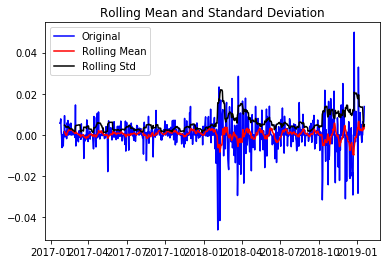

In [10]:
dftest(djia_df['djia_per'])
#Data stationary

Test Statistic         -9.332945e+00
p-value                 9.223569e-16
Lags Used               3.000000e+00
Observations Used       7.220000e+02
Critical Value (1%)    -3.439440e+00
Critical Value (5%)    -2.865551e+00
Critical Value (10%)   -2.568906e+00
dtype: float64


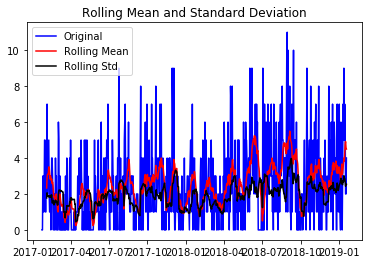

In [19]:
dftest(data['sentiment'])

Test Statistic         -5.679538e+00
p-value                 8.549296e-07
Lags Used               0.000000e+00
Observations Used       7.250000e+02
Critical Value (1%)    -3.439402e+00
Critical Value (5%)    -2.865535e+00
Critical Value (10%)   -2.568897e+00
dtype: float64


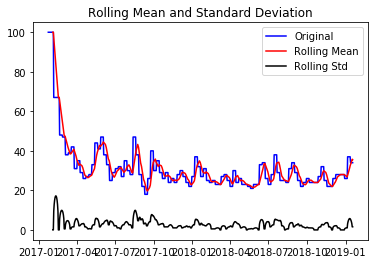

In [14]:
dftest(data['trump_kw'])

Test Statistic           -2.496667
p-value                   0.116287
Lags Used                14.000000
Observations Used       711.000000
Critical Value (1%)      -3.439581
Critical Value (5%)      -2.865614
Critical Value (10%)     -2.568939
dtype: float64


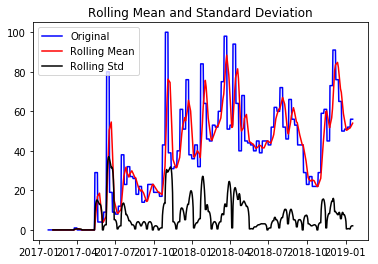

In [15]:
dftest(data['trump_mueller_kw'])

## OLS Model

In [20]:
data.columns

Index(['net_approval', 'Price', 'compound', 'sentiment', 'trump_kw',
       'trump_mueller_kw'],
      dtype='object')

In [26]:
ols_data = data.drop(['compound', 'sentiment', 'trump_kw',
       'trump_mueller_kw'], axis=1)

In [34]:
ols_data['Price'] = djia_df.pct_change().fillna(method='bfill')
ols_data['djia_per'] = ols_data['Price']
ols_data = ols_data.drop(['Price'], axis=1 )

In [35]:
ols_data.head()

,net_approval,djia_per
2017-01-23,4.400803,0.005700
2017-01-24,3.939187,0.005700
2017-01-25,4.297997,0.007824
2017-01-26,3.376683,0.001614
2017-01-27,2.589067,-0.000355


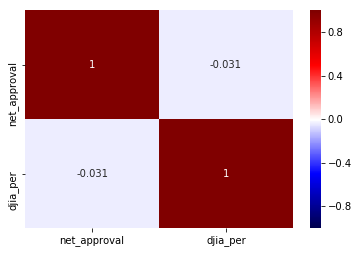

In [36]:
# example of a better corr matrix
sns.heatmap(ols_data.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);